# Requirements

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm

anscombe = pd.read_csv("anscombe.csv")
sns.set(style="white")
colours = ["orange", "blue", "green", "black"]
print(anscombe)

    x123     y1    y2     y3    x4     y4
0   10.0   8.04  9.14   7.46   8.0   6.58
1    8.0   6.95  8.14   6.77   8.0   5.76
2   13.0   7.58  8.74  12.74   8.0   7.71
3    9.0   8.81  8.77   7.11   8.0   8.84
4   11.0   8.33  9.26   7.81   8.0   8.47
5   14.0   9.96  8.10   8.84   8.0   7.04
6    6.0   7.24  6.13   6.08   8.0   5.25
7    4.0   4.26  3.10   5.39  19.0  12.50
8   12.0  10.84  9.13   8.15   8.0   5.56
9    7.0   4.82  7.26   6.42   8.0   7.91
10   5.0   5.68  4.74   5.73   8.0   6.89


# Making the CSV usable

In [57]:
anscombe_melted = anscombe.melt(
    id_vars=["x123","x4"], 
    value_vars=["y1","y2","y3","y4"],
    var_name="dataset",
    value_name="y"
)
anscombe_melted["dataset"] = anscombe_melted["dataset"].replace({
    "y1": "I",
    "y2": "II",
    "y3": "III",
    "y4": "IV"
})

anscombe_melted["x"] = anscombe_melted.apply(lambda row: row["x123"] if row["dataset"] in ["I","II","III"] else row["x4"], axis=1)

anscombe_melted = anscombe_melted.drop(columns=["x123","x4"])

# Summary Stats

In [65]:
def dataset_stats(df, name):
    x = df["x"]
    y = df["y"]
    
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    std_x = np.std(x, ddof=1)
    std_y = np.std(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0, 1]
    corr = np.corrcoef(x, y)[0, 1]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    r_squared = r_value**2
    
    return {
        "Dataset": name,
        "Mean x": round(mean_x, 2),
        "Mean y": round(mean_y, 2),
        "Var x": round(var_x, 2),
        "Var y": round(var_y, 2),
        "Std x": round(std_x, 2),
        "Std y": round(std_y, 2),
        "Cov xy": round(cov_xy, 2),
        "Correlation": round(corr, 3),
        "Slope": round(slope, 3),
        "Intercept": round(intercept, 3),
        "R²": round(r_squared, 3)
    }

results = []
for dataset_name, group in anscombe_melted.groupby("dataset"):
    results.append(dataset_stats(group, dataset_name))
    
stats_df = pd.DataFrame(results)

print(stats_df.set_index("Dataset").T)

Dataset           I      II     III      IV
Mean x        9.000   9.000   9.000   9.000
Mean y        7.500   7.500   7.500   7.500
Var x        11.000  11.000  11.000  11.000
Var y         4.130   4.130   4.120   4.120
Std x         3.320   3.320   3.320   3.320
Std y         2.030   2.030   2.030   2.030
Cov xy        5.500   5.500   5.500   5.500
Correlation   0.816   0.816   0.816   0.817
Slope         0.500   0.500   0.500   0.500
Intercept     3.000   3.001   3.002   3.002
R²            0.667   0.666   0.666   0.667


# Scatter + regression line (seaborn) - one figure per dataset

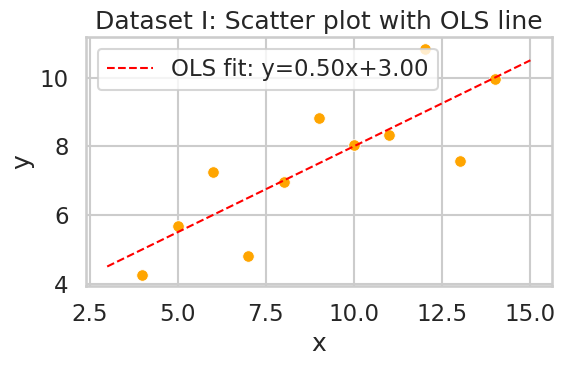

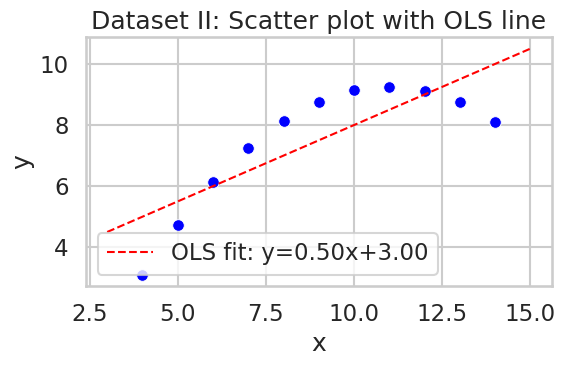

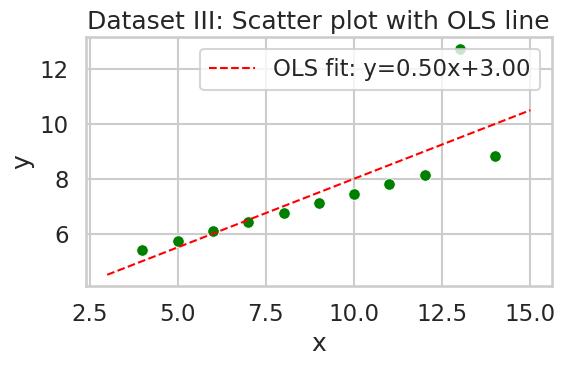

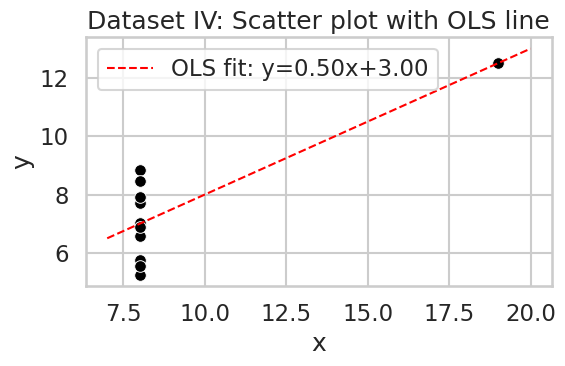

In [56]:
sns.set(style="whitegrid", context="talk")
for (name, group), colour in zip(anscombe_melted.groupby('dataset'), colours):
    plt.figure(figsize=(6,4))
    ax = sns.scatterplot(data=group, x='x', y='y', s=70, color=colour)
    
    X = sm.add_constant(group['x'])
    model = sm.OLS(group['y'], X).fit()
    xs = np.linspace(group['x'].min() - 1, group['x'].max() + 1, 100)
    ys = model.params['const'] + model.params['x'] * xs
    plt.plot(xs, ys, linestyle='--', linewidth=1.5, color="red",
             label=f"OLS fit: y={model.params['x']:.2f}x+{model.params['const']:.2f}")
    plt.title(f"Dataset {name}: Scatter plot with OLS line")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"scatter_reg_rayan_{name}.png", dpi=200)

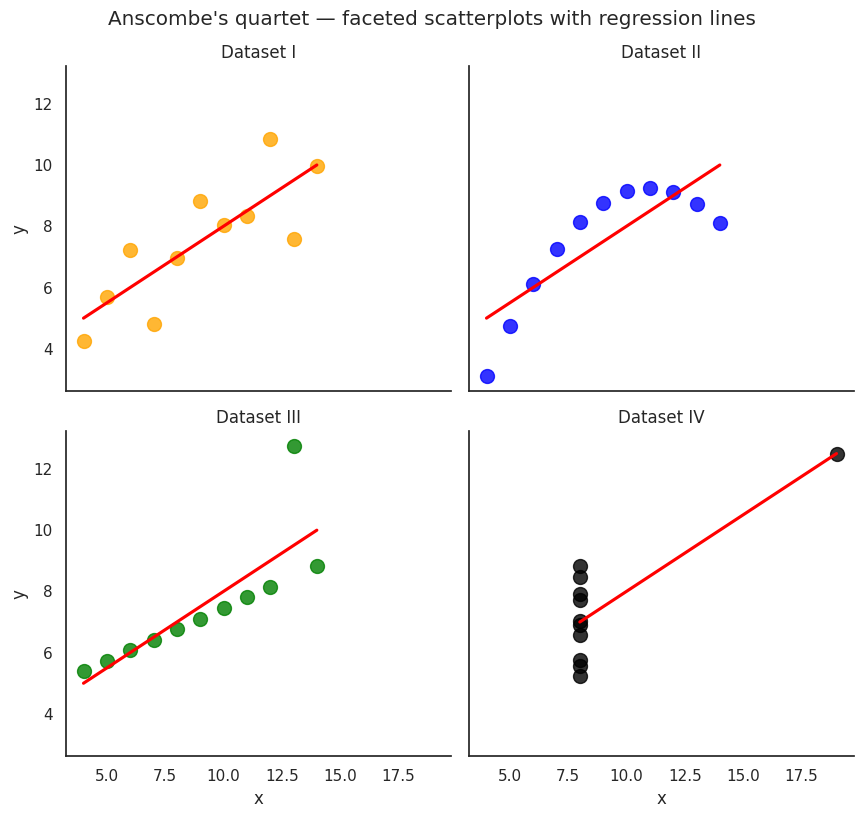

In [54]:
g = sns.lmplot(
    data=anscombe_melted,
    x="x",
    y="y",
    col="dataset",
    col_wrap=2,
    ci=None,
    height=4,
    aspect=1.1,
    scatter_kws={"s":100}
)

titles = ["Dataset I", "Dataset II", "Dataset III", "Dataset IV"]

for ax, title, colour in zip(g.axes, titles, colours):
    ax.set_title(title)

    for collection in ax.collections:
        collection.set_facecolor(colour)
        collection.set_edgecolor(colour)

    ax.lines[0].set_color("red")

plt.suptitle("Anscombe's quartet — faceted scatterplots with regression lines", y=1.02)
g.savefig(f"resid_rayan.png", dpi=200)
